In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pydicom, cv2, torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import multiprocessing as mp

mp.set_start_method('fork', force=True)

/Users/jiwoo_noh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Cohort Exploration

In [4]:
patient_df = pd.read_csv('/Users/jiwoo_noh/Downloads/admissions.csv')
dicom_df   = pd.read_csv('/Users/jiwoo_noh/Downloads/cxr-record-list.csv')

dicom_filtered = dicom_df[
    dicom_df['subject_id'].astype(str).str.startswith(('10', '12', '15', '17', '18', '19'))
]

merged = dicom_filtered.merge(
    patient_df[['subject_id', 'ethnicity']],
    on='subject_id',
    how='inner'
)

to_drop = ['OTHER', 'UNKNOWN', 'UNABLE TO OBTAIN', 'AMERICAN INDIAN/ALASKA NATIVE']

merged = merged[~merged['ethnicity'].isin(to_drop)]

result = merged[['subject_id', 'ethnicity', 'path']]

result.to_csv(
    '/Users/jiwoo_noh/Downloads/patient_ethnicity_with_path.csv',
    index=False
)


In [5]:
labels_df = pd.read_csv('/Users/jiwoo_noh/Downloads/patient_ethnicity_with_path.csv')

eth_df = labels_df[['subject_id','ethnicity']].drop_duplicates()
counts = eth_df['subject_id'].value_counts()
ambiguous_ids = counts[counts > 1].index.tolist()

if ambiguous_ids:
    print(f"Removing {len(ambiguous_ids)} patients with inconsistent ethnicity:", ambiguous_ids)

labels_df = labels_df[~labels_df['subject_id'].isin(ambiguous_ids)].reset_index(drop=True)
labels = labels_df['ethnicity']
subject_id = labels_df['subject_id']

Removing 214 patients with inconsistent ethnicity: [19919017, 18110020, 19014160, 19011622, 19936081, 18341991, 10942097, 15874847, 15057166, 10731206, 17183367, 15784514, 19565063, 10264068, 12604466, 12704996, 10949720, 18730486, 15506972, 15140950, 10056612, 12789108, 17102345, 17101277, 15574754, 17350899, 12034618, 15416392, 19299811, 19671332, 12297145, 12106493, 10270108, 15509202, 12697173, 10720865, 15966360, 17813449, 19763886, 18566742, 15071748, 17981662, 10367781, 15666867, 10827166, 12903377, 19821816, 10190829, 15608828, 17922113, 15853461, 19962126, 15800920, 17382149, 18905773, 12580408, 18532084, 19023015, 10253747, 17548885, 12125322, 18334912, 12021934, 18333592, 15677158, 15326328, 17720066, 17809813, 18728113, 12379909, 17447497, 12497543, 19575197, 18155258, 17930009, 15600427, 19674244, 18942108, 10756520, 18769702, 15393401, 12077819, 18767874, 12250460, 18962557, 19729296, 12673327, 12081472, 19151064, 19731136, 12847427, 10692049, 12450853, 17163115, 17852330

ethnicity
WHITE                     969968
BLACK/AFRICAN AMERICAN    358786
HISPANIC/LATINO            91197
ASIAN                      38288
Name: count, dtype: int64
29955


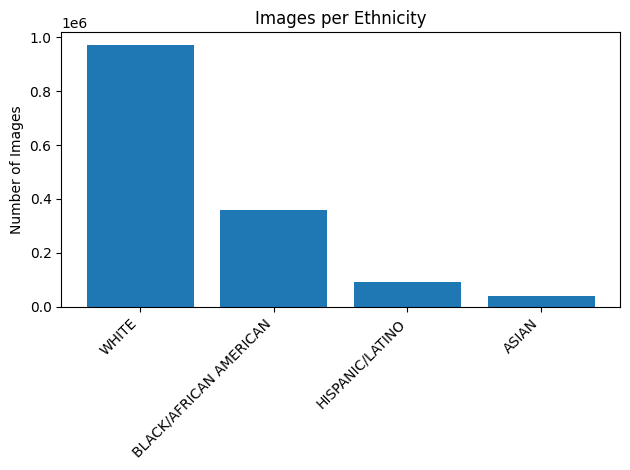

In [6]:
# calculate data demographics
race_counts = labels_df['ethnicity'].value_counts()
print(race_counts)

unique_subject = labels_df['subject_id'].unique()

print(len(unique_subject))

# plotting race distribution
plt.figure()
plt.bar(race_counts.index, race_counts.values)
plt.ylabel('Number of Images')
plt.title('Images per Ethnicity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

DICOM Preprocessing

In [7]:
import os, pydicom, pandas as pd
from pydicom import config
config.use_gdcm_handler = True

local_path_stem = '/Users/jiwoo_noh/Downloads/physionet.org/files/mimic-cxr/2.1.0/'

valid_rows = []
labels_dict = {}

for _, row in labels_df.iterrows():
    patient_id = row['subject_id']
    full_path  = os.path.join(local_path_stem, row['path'])
    if not os.path.exists(full_path):
        continue

    try:
        ds = pydicom.dcmread(full_path, force=True)
        _  = ds.pixel_array   # will throw if unreadable
    except Exception as e:
        # print(f"Skipping corrupted {full_path}: {e}")
        continue

    new_row = row.copy()
    new_row['path'] = full_path         
    valid_rows.append(new_row)

    # store for later dataset creation
    labels_dict[(patient_id, full_path)] = row['ethnicity']

# save the new list of patients (this is the data we will actually have access to)
valid_df = pd.DataFrame(valid_rows)

unique_labels = sorted(valid_df['ethnicity'].unique())
label2idx     = {lab: i for i, lab in enumerate(unique_labels)}
idx2label     = {i: lab for lab, i in label2idx.items()}
num_classes   = len(unique_labels)

print("Classes:", unique_labels)
print("Mapping:", label2idx)

valid_df.to_csv('downloaded_data_info.csv', index=False)


Classes: ['ASIAN', 'BLACK/AFRICAN AMERICAN', 'HISPANIC/LATINO', 'WHITE']
Mapping: {'ASIAN': 0, 'BLACK/AFRICAN AMERICAN': 1, 'HISPANIC/LATINO': 2, 'WHITE': 3}


ethnicity
BLACK/AFRICAN AMERICAN    12722
WHITE                     12258
HISPANIC/LATINO             988
ASIAN                       122
Name: count, dtype: int64
Number of unique patients:330


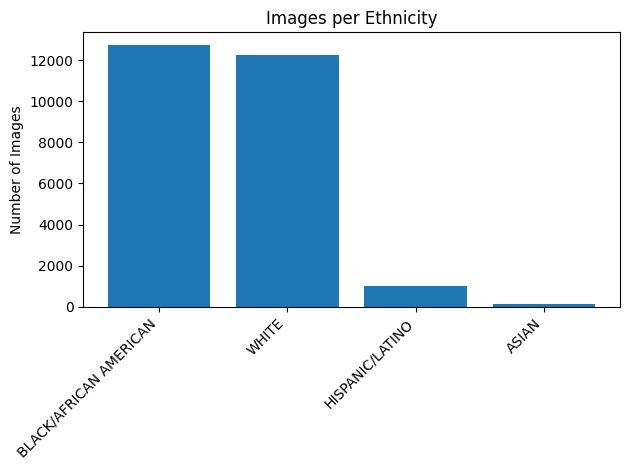

In [8]:
## plot the final patient demographics after filtering and downloading 
race_counts = valid_df['ethnicity'].value_counts()
print(race_counts)

unique_subject = valid_df['subject_id'].unique()

print(f'Number of unique patients:{len(unique_subject)}')

plt.figure()
plt.bar(race_counts.index, race_counts.values)
plt.ylabel('Number of Images')
plt.title('Images per Ethnicity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [9]:
# by patient train/validation/test split
# stratified by ethnicity
patient_labels = valid_df.groupby('subject_id')['ethnicity'].first()
unique_patients = patient_labels.index.tolist()
patient_label_list = patient_labels.tolist()

# 70 train, val 20, test 10
test_patients, temp_patients = train_test_split(
    unique_patients,
    test_size=0.9,
    stratify=patient_label_list,  # <— keeps your test class‐balance
    random_state=42
)
# now split temp_patients into train / val
temp_labels = patient_labels.loc[temp_patients].tolist()
train_patients, val_patients = train_test_split(
    temp_patients,
    test_size=0.222222,          # ≈20% of original full cohort
    stratify=temp_labels,       
    random_state=42
)

print("Patient size: \n")
print(f"Train size: {len(train_patients)}")
print(f"Val   size: {len(val_patients)}")
print(f"Test  size: {len(test_patients)}")

# complete training, validation, testing datasets because patients have more than one dicom
train_items = []
val_items = []
test_items = []

for (patient_id, path) in labels_dict.keys():
    if patient_id in train_patients:
        train_items.append((patient_id, path))
    elif patient_id in val_patients:
        val_items.append((patient_id, path))
    elif patient_id in test_patients:
        test_items.append((patient_id, path))
    else:
        print("Patient ID: {patient_id} not found in any split but is in the processed images. Something is seriously wrong. Taco.")


# output lists of patient, path pairs as keys
# need to have labels_dict dictionary loaded in --> tensors as items in this dictionary

Patient size: 

Train size: 231
Val   size: 66
Test  size: 33


In [10]:
import os
import pydicom
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# 1) Dataset class 
class DicomDataset(Dataset):
    def __init__(self, items, labels_dict, label2idx,
                 transform=None, strong_transform=None):
        self.items            = items
        self.labels           = labels_dict
        self.label2idx        = label2idx
        self.transform        = transform
        self.strong_transform = strong_transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        pid, path = self.items[idx]
        ds  = pydicom.dcmread(path)
        arr = ds.pixel_array.astype('float32')
        arr = (arr - arr.min()) / (arr.ptp() + 1e-6)
        img = Image.fromarray((arr * 255).astype('uint8'))

        raw_label = self.labels[(pid, path)]
        # if we have a strong_transform AND this is a minority class, use it
        if (
            raw_label in ['ASIAN', 'HISPANIC/LATINO']
            and self.strong_transform is not None
        ):
            img = self.strong_transform(img)
        else:
            # fallback to the normal one (must be set)
            img = self.transform(img)

        label = self.label2idx[raw_label]
        return img, label


# 2) Compute train‐set mean & std 
def compute_mean_std(loader):
    mean = 0.0
    var  = 0.0
    n    = 0
    for imgs, _ in loader:
        # imgs: [B, 1, H, W]
        b = imgs.size(0)
        imgs = imgs.view(b, imgs.size(1), -1)   # [B, C, H*W]
        mean += imgs.mean(2).sum(0)
        var  += imgs.var(2, unbiased=False).sum(0)
        n    += b
    mean /= n
    var  /= n
    std   = torch.sqrt(var)
    return mean, std


stats_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),   # yields [1,H,W] in [0,1]
])

stats_loader = DataLoader(
    DicomDataset(train_items, labels_dict, label2idx, transform=stats_transform),
    batch_size=32, shuffle=False, num_workers=0
)

train_mean, train_std = compute_mean_std(stats_loader)
print(f"Train mean: {train_mean.item():.4f},  std: {train_std.item():.4f}")


# 3) final transforms
train_transform = transforms.Compose([ # data augmentation to prevent overfitting
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize([train_mean.item()], [train_std.item()]),
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([train_mean.item()], [train_std.item()]),
])

# Stronger transform for asian and hispanic population
strong_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(0.8,1.2), shear=10),
    transforms.ToTensor(),                     
    transforms.RandomErasing(p=0.3),         
    transforms.Normalize([train_mean.item()], 
                         [train_std.item()]),
])


Train mean: 0.5037,  std: 0.2510


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import densenet121
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pydicom
import numpy as np
from PIL import Image
from tqdm import tqdm

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

unique_labels = sorted(set(labels_dict.values()))
label2idx     = {lab: idx for idx, lab in enumerate(unique_labels)}
num_classes   = len(unique_labels)
print(f"Classes ({num_classes}): {unique_labels}")

# ─── Grid of hyper-parameters ────────────────────────────────────────────────
batch_size_options      = [16, 32, 64]
learning_rate_options   = [1e-4, 1e-5]
weight_decay_options    = [1e-3, 1e-4]

# ─── Storage for results ─────────────────────────────────────────────────────
records = []

for batch_size in batch_size_options:
    for learning_rate in learning_rate_options:
        for weight_decay in weight_decay_options:

            print(f"\n======== batch_size={batch_size}, "
                  f"learning_rate={learning_rate}, "
                  f"weight_decay={weight_decay} ========")

            # ─── DataLoaders ────────────────────────────────────────────────
            train_loader = DataLoader(
                DicomDataset(train_items, labels_dict, label2idx,
                             transform=train_transform,
                             strong_transform=strong_transform),
                batch_size=batch_size,
                shuffle=True,
                num_workers=0,
                pin_memory=True
            )
            val_loader = DataLoader(
                DicomDataset(val_items, labels_dict, label2idx,
                             transform=val_transform),
                batch_size=batch_size,
                shuffle=False,
                num_workers=0,
                pin_memory=True
            )
            test_loader = DataLoader(
                DicomDataset(val_items, labels_dict, label2idx,
                             transform=val_transform),
                batch_size=batch_size,
                shuffle=False,
                num_workers=0,
                pin_memory=True
            )

            # ─── Model setup ────────────────────────────────────────────────
            model = densenet121(pretrained=True)
            old_conv = model.features.conv0
            new_conv = nn.Conv2d(
                in_channels=1,
                out_channels=old_conv.out_channels,
                kernel_size=old_conv.kernel_size,
                stride=old_conv.stride,
                padding=old_conv.padding,
                bias=(old_conv.bias is not None)
            )
            with torch.no_grad():
                new_conv.weight[:] = old_conv.weight.mean(dim=1, keepdim=True)
                if old_conv.bias is not None:
                    new_conv.bias[:] = old_conv.bias
            model.features.conv0 = new_conv

            model.classifier = nn.Linear(model.classifier.in_features, num_classes)
            model = model.to(device)

            # ─── Optimizer & scheduler ──────────────────────────────────────
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(
                model.parameters(),
                lr=learning_rate,
                weight_decay=weight_decay
            )
            scheduler = optim.lr_scheduler.StepLR(
                optimizer, step_size=7, gamma=0.1
            )

            # ─── Training loop ──────────────────────────────────────────────
            best_val_accuracy = 0.0
            num_epochs = 15

            for epoch in range(1, num_epochs+1):
                # — Training —
                model.train()
                running_loss = correct = total = 0
                for images, labels in tqdm(train_loader, desc=f"Epoch {epoch} ▶ Train"):
                    images, labels = images.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item() * images.size(0)
                    preds = outputs.argmax(dim=1)
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)

                # — Validation —
                model.eval()
                val_correct = val_total = 0
                with torch.no_grad():
                    for images, labels in tqdm(val_loader, desc=f"Epoch {epoch} ▶ Val"):
                        images, labels = images.to(device), labels.to(device)
                        outputs = model(images)
                        preds = outputs.argmax(dim=1)
                        val_correct += (preds == labels).sum().item()
                        val_total += labels.size(0)

                val_accuracy = val_correct / val_total
                scheduler.step()

                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy

            print(f"→ Best validation accuracy = {best_val_accuracy:.4f}")

            # ─── Save model for this combination ──────────────────────────
            filename = (
                f"model_batch_size_{batch_size}"
                f"_learning_rate_{learning_rate}"
                f"_weight_decay_{weight_decay}.pth"
            )
            torch.save(model.state_dict(), filename)

            # ─── Record results ───────────────────────────────────────────
            records.append({
                "batch_size":      batch_size,
                "learning_rate":   learning_rate,
                "weight_decay":    weight_decay,
                "best_val_accuracy": best_val_accuracy,
                "model_file":      filename
            })

# ─── Summarize all runs ──────────────────────────────────────────────────────
df = pd.DataFrame(records)
df = df.sort_values("best_val_accuracy", ascending=False).reset_index(drop=True)
print("\nAll runs sorted by validation accuracy:")
print(df.to_string(index=False))
print("\nBest overall configuration:\n", df.iloc[0])


Using device: mps
Classes (4): ['ASIAN', 'BLACK/AFRICAN AMERICAN', 'HISPANIC/LATINO', 'WHITE']


/Users/jiwoo_noh/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jiwoo_noh/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1 ▶ Val: 100%|██████████| 15/15 [00:20<00:00,  1.35s/it]



Epoch 1/15 — Train Loss: 0.7402, Acc: 0.7137 | Val Loss: 0.8569, Acc: 0.6271
→ New best model saved
------------------------------------------------------------


Epoch 2 ▶ Val: 100%|██████████| 15/15 [00:20<00:00,  1.38s/it]



Epoch 2/15 — Train Loss: 0.3903, Acc: 0.8594 | Val Loss: 0.9663, Acc: 0.6398
→ New best model saved
------------------------------------------------------------


Epoch 3 ▶ Val: 100%|██████████| 15/15 [00:14<00:00,  1.00it/s]



Epoch 3/15 — Train Loss: 0.2974, Acc: 0.8969 | Val Loss: 0.8827, Acc: 0.6822
→ New best model saved
------------------------------------------------------------


Epoch 4 ▶ Val: 100%|██████████| 15/15 [00:16<00:00,  1.11s/it]



Epoch 4/15 — Train Loss: 0.2327, Acc: 0.9153 | Val Loss: 0.8742, Acc: 0.7097
→ New best model saved
------------------------------------------------------------


Epoch 5 ▶ Val: 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]



Epoch 5/15 — Train Loss: 0.2104, Acc: 0.9205 | Val Loss: 0.9589, Acc: 0.6716
------------------------------------------------------------


Epoch 6 ▶ Val: 100%|██████████| 15/15 [00:17<00:00,  1.18s/it]



Epoch 6/15 — Train Loss: 0.1843, Acc: 0.9309 | Val Loss: 0.8674, Acc: 0.7182
→ New best model saved
------------------------------------------------------------


Epoch 7 ▶ Val: 100%|██████████| 15/15 [00:16<00:00,  1.07s/it]



Epoch 7/15 — Train Loss: 0.1387, Acc: 0.9470 | Val Loss: 1.0774, Acc: 0.6928
------------------------------------------------------------


Epoch 8 ▶ Val: 100%|██████████| 15/15 [00:16<00:00,  1.08s/it]



Epoch 8/15 — Train Loss: 0.1007, Acc: 0.9695 | Val Loss: 0.9134, Acc: 0.7246
→ New best model saved
------------------------------------------------------------


Epoch 9 ▶ Val: 100%|██████████| 15/15 [00:15<00:00,  1.01s/it]



Epoch 9/15 — Train Loss: 0.0763, Acc: 0.9787 | Val Loss: 0.9147, Acc: 0.7267
→ New best model saved
------------------------------------------------------------


Epoch 10 ▶ Val: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]



Epoch 10/15 — Train Loss: 0.0681, Acc: 0.9804 | Val Loss: 0.9197, Acc: 0.7331
→ New best model saved
------------------------------------------------------------


Epoch 11 ▶ Val: 100%|██████████| 15/15 [00:15<00:00,  1.04s/it]



Epoch 11/15 — Train Loss: 0.0653, Acc: 0.9798 | Val Loss: 0.9117, Acc: 0.7267
------------------------------------------------------------


Epoch 12 ▶ Val: 100%|██████████| 15/15 [00:15<00:00,  1.01s/it]



Epoch 12/15 — Train Loss: 0.0648, Acc: 0.9793 | Val Loss: 0.9287, Acc: 0.7331
------------------------------------------------------------


Epoch 13 ▶ Val: 100%|██████████| 15/15 [00:14<00:00,  1.01it/s]



Epoch 13/15 — Train Loss: 0.0661, Acc: 0.9810 | Val Loss: 0.9273, Acc: 0.7415
→ New best model saved
------------------------------------------------------------


Epoch 14 ▶ Val: 100%|██████████| 15/15 [00:15<00:00,  1.05s/it]



Epoch 14/15 — Train Loss: 0.0640, Acc: 0.9804 | Val Loss: 0.9453, Acc: 0.7288
------------------------------------------------------------


Epoch 15 ▶ Val: 100%|██████████| 15/15 [00:15<00:00,  1.02s/it]


Epoch 15/15 — Train Loss: 0.0700, Acc: 0.9752 | Val Loss: 1.0336, Acc: 0.7225
------------------------------------------------------------
Done. Best Val Acc: 0.7415


In [12]:
batch_size = test_loader.batch_size
# chunk your flat list into the same batch‐sized groups
batched_items = [
    test_items[i : i+batch_size]
    for i in range(0, len(test_items), batch_size)
]

all_pids, all_paths, all_preds, all_probs, all_truths = [], [], [], [], []

model.load_state_dict(torch.load("best_densenet_ethnicity.pth"))
model.eval()

# Compute test accuracy ───────────────────────────────────────────────
correct = 0
total   = 0
with torch.no_grad():
    for imgs, labs in test_loader:
        imgs, labs = imgs.to(device), labs.to(device)
        out   = model(imgs)
        preds = out.argmax(dim=1)
        correct += (preds == labs).sum().item()
        total   += labs.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

with torch.no_grad():
    for (imgs, labs), batch in zip(test_loader, batched_items):
        imgs = imgs.to(device)
        out  = model(imgs)
        probs = torch.softmax(out, dim=1)
        preds = probs.argmax(dim=1)

        labs_cpu  = labs.cpu().tolist()
        preds_cpu = preds.cpu().tolist()
        probs_cpu = probs.cpu().tolist()

        # now `batch` is a list of (pid,path) of length == imgs.size(0)
        for (pid,path), truth_idx, pred_idx, prob in zip(
            batch, labs_cpu, preds_cpu, probs_cpu
        ):
            all_pids.append(pid)
            all_paths.append(path)
            all_truths.append(idx2label[truth_idx])
            all_preds.append(idx2label[pred_idx])
            all_probs.append(prob)

import pandas as pd
df = pd.DataFrame({
    "subject_id":   all_pids,
    "dicom_path":   all_paths,
    "true_label":   all_truths,
    "predicted":    all_preds,
    "probabilities": all_probs,
})
df.to_csv("best_model_pred.csv", index=False)
print("Saved best_model_pred.csv with", len(df), "rows.")


Test Accuracy: 0.7239
Saved best_model_pred.csv with 268 rows.


Classification Report:

                        precision    recall  f1-score   support

                 ASIAN       0.00      0.00      0.00        15
BLACK/AFRICAN AMERICAN       0.39      0.43      0.41        51
       HISPANIC/LATINO       0.00      0.00      0.00        26
                 WHITE       0.82      0.98      0.89       176

              accuracy                           0.72       268
             macro avg       0.30      0.35      0.32       268
          weighted avg       0.61      0.72      0.66       268



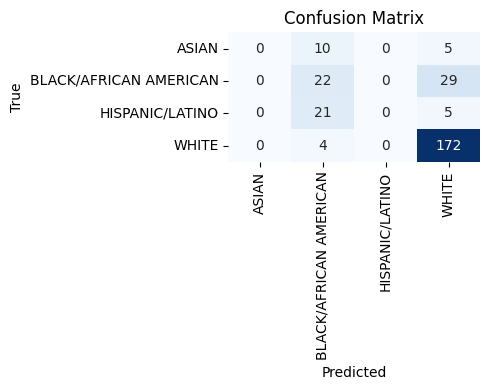

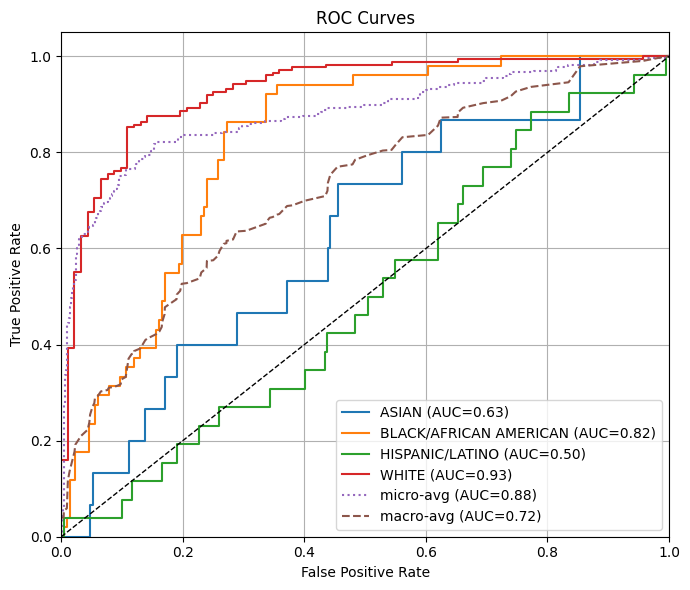

In [13]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    roc_curve,
    auc,
)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 1) Collect predictions, labels, and probabilities
model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for imgs, labs in test_loader:
        imgs = imgs.to(device)
        out  = model(imgs)                  # logits
        probs = torch.softmax(out, dim=1)   # [B,C]
        preds = probs.argmax(dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labs.numpy())
        all_probs.append(probs.cpu().numpy())

all_preds  = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)
all_probs  = np.vstack(all_probs)  # shape (N, C)

# 2) Classification report & per‑class precision/recall/f1/support
print("Classification Report:\n")
print(classification_report(
    all_labels,
    all_preds,
    labels=list(range(len(unique_labels))),
    target_names=unique_labels,
    zero_division=0
))

# 3) Confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(unique_labels))))
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=unique_labels,
            yticklabels=unique_labels,
            cmap="Blues", cbar=False,
            ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.tight_layout()

# save to disk
fig.savefig("confusion_matrix_best.jpg", dpi=300)
plt.show()
plt.close(fig)

# 4) ROC Curves & AUC
n_classes = len(unique_labels)
fpr, tpr, roc_auc = {}, {}, {}

# per-class ROC & AUC
for i in range(n_classes):
    y_true_i  = (all_labels == i).astype(int)
    y_score_i = all_probs[:, i]
    if 0 < y_true_i.sum() < len(y_true_i):
        fpr[i], tpr[i], _ = roc_curve(y_true_i, y_score_i)
        roc_auc[i] = auc(fpr[i], tpr[i])

# micro-average (treat every element of every class equally)
y_true_bin = np.eye(n_classes)[all_labels]  # one-hot encode
fpr["micro"], tpr["micro"], _ = roc_curve(
    y_true_bin.ravel(), all_probs.ravel()
)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# macro-average (unweighted mean of class‐wise curves)
# 1) aggregate all fpr points
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes) if i in fpr]))
# 2) interpolate each class’s tpr at these points, then average
mean_tpr = np.zeros_like(all_fpr)
seen = 0
for i in range(n_classes):
    if i in fpr:
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        seen += 1
mean_tpr /= seen
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 5) Plot & save to disk
fig, ax = plt.subplots(figsize=(7,6))
for i in range(n_classes):
    if i in roc_auc:
        ax.plot(fpr[i], tpr[i],
                label=f"{unique_labels[i]} (AUC={roc_auc[i]:.2f})")
ax.plot(fpr["micro"], tpr["micro"],
        label=f"micro-avg (AUC={roc_auc['micro']:.2f})", linestyle=':')
ax.plot(fpr["macro"], tpr["macro"],
        label=f"macro-avg (AUC={roc_auc['macro']:.2f})", linestyle='--')
ax.plot([0,1], [0,1], "k--", lw=1)

ax.set_xlim(0,1)
ax.set_ylim(0,1.05)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curves")
ax.legend(loc="lower right")
ax.grid(True)
plt.tight_layout()

# save figure
fig.savefig("roc_curves_best.jpg", dpi=300)
plt.show()
plt.close(fig)


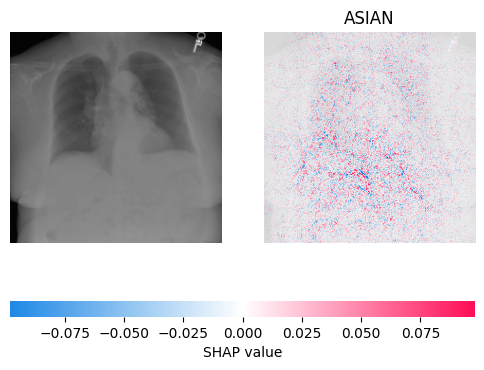

In [19]:
import shap
import numpy as np
import torch

model.eval()
device = next(model.parameters()).device

# 1) Grab a small batch to explain
test_imgs, _ = next(iter(test_loader))
test_imgs = test_imgs[:1].to(device)   # e.g. first 3 samples

# 2) Build a background set of, say, 10 training images
bg_size = 10
bg_idxs = np.random.choice(len(train_loader.dataset), bg_size, replace=False)
background = torch.stack([ train_loader.dataset[i][0] for i in bg_idxs ]).to(device)

# 3) Create the GradientExplainer
explainer = shap.GradientExplainer(model, background)

# 4) Compute SHAP values: returns list of C arrays, each (N,1,H,W)
raw_shap = explainer.shap_values(test_imgs)

# 5) Squeeze out that dummy channel → each becomes (N, H, W)
shap_values = []
for arr in raw_shap:
    # if channel is dim=1
    if arr.ndim == 4 and arr.shape[1] == 1:
        arr = arr[:,0,...]
    # if channel is dim=-1
    elif arr.ndim == 4 and arr.shape[-1] == 1:
        arr = arr[...,0]
    shap_values.append(arr)

# 6) Prepare your pixel images as plain (N, H, W)
#    test_imgs is (N,1,H,W) → (N,H,W,1) → squeeze → (N,H,W)
pixels = test_imgs.cpu().numpy().transpose(0,2,3,1)[...,0]

# 7) One call to the new image plot API
#    Rows = samples, Columns = classes
shap.plots.image(
    shap_values,
    pixels,
    labels=unique_labels  # class names for each column
)
